 **Note** : I have taken 5 classes of animals from the dataset.
 *(Elephant, Horse, Kangaroo, Lion, Octopus)*

First normal implementation of the model , afterwards 3-fold cross validation implementation



In [ ]:
#Constant values
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

## Data Loading

In [ ]:
# Importing the data through image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Animals Dataset/5-class",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 300 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['elephant', 'horse', 'kangaroo', 'lion', 'octopus']

In [ ]:
len(dataset)

10

## Visualising the images

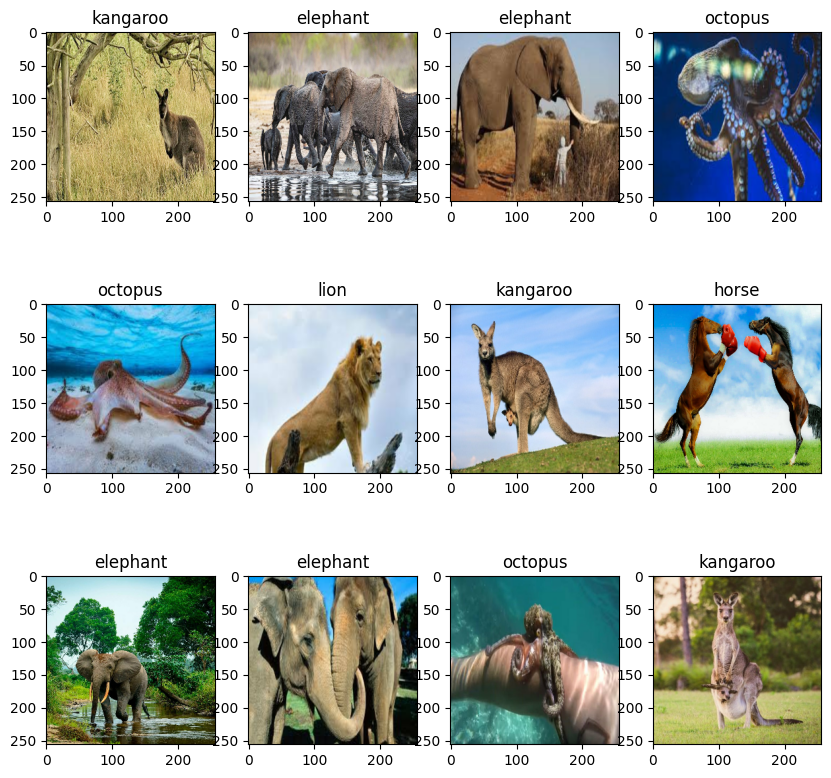

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

## Data Splitting

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1 , test_split=0.1, shuffle_size=1000):
    ds_size = len(ds)

    train_size = int(train_split * ds_size)        # train_size = 0.8
    val_size = int(val_split * ds_size)            # val_size = 0.1

    train_ds = ds.take(train_size)                 # takes 8 batches

    val_ds = ds.skip(train_size).take(val_size)    # takes 1 batches
    test_ds = ds.skip(train_size).skip(val_size)   # takes 1 batches

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

8
1
1


### Data Preprocessing

In [ ]:
# Cache Transformation : This will save some operations (like file opening and data reading) from being executed during each epoch
# Prefetching overlaps the preprocessing and model execution of a training step

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Resizing the images to (256,256) pixel size, and scaling all the images to the range of 0 to 1
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Increasing the diversity of the training data by some image transformations like : contrast, zoom, horizontal/vertical flip, rotation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomZoom(0.15),
  layers.experimental.preprocessing.RandomContrast(0.15),
])

### Model Building

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5     # no. of classes

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
8/8 [==============================] - 1s 68ms/step - loss: 0.5789 - accuracy: 0.7969 - val_loss: 0.6283 - val_accuracy: 0.7812
Epoch 2/50
8/8 [==============================] - 0s 63ms/step - loss: 0.5528 - accuracy: 0.7695 - val_loss: 0.4590 - val_accuracy: 0.9062
Epoch 3/50
8/8 [==============================] - 0s 63ms/step - loss: 0.5949 - accuracy: 0.7891 - val_loss: 0.6215 - val_accuracy: 0.7812
Epoch 4/50
8/8 [==============================] - 1s 64ms/step - loss: 0.5814 - accuracy: 0.7773 - val_loss: 0.6942 - val_accuracy: 0.7188
Epoch 5/50
8/8 [==============================] - 0s 63ms/step - loss: 0.6470 - accuracy: 0.7695 - val_loss: 1.2113 - val_accuracy: 0.5938
Epoch 6/50
8/8 [==============================] - 0s 63ms/step - loss: 0.6023 - accuracy: 0.7578 - val_loss: 0.7638 - val_accuracy: 0.8438
Epoch 7/50
8/8 [==============================] - 0s 62ms/step - loss: 0.5214 - accuracy: 0.7969 - val_loss: 0.8214 - val_accuracy: 0.7188
Epoch 8/50
8/8 [===========

In [ ]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 0s 23ms/step - loss: 0.3924 - accuracy: 0.9167


In [ ]:
scores


[0.3923856317996979, 0.9166666865348816]

### Classification matrices

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score , confusion_matrix

# Get the predicted labels for the test dataset
predicted_labels = np.argmax(model.predict(test_ds), axis=1)

# Get the true labels for the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)



1/1 [==============================] - 0s 10ms/step


In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

    elephant       0.75      1.00      0.86         3
       horse       1.00      0.67      0.80         3
    kangaroo       1.00      1.00      1.00         2
        lion       1.00      1.00      1.00         3
     octopus       1.00      1.00      1.00         1

    accuracy                           0.92        12
   macro avg       0.95      0.93      0.93        12
weighted avg       0.94      0.92      0.91        12



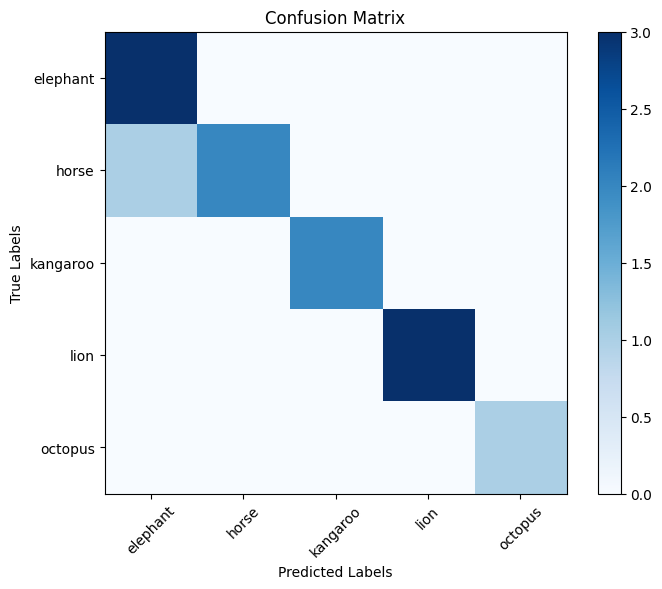

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.show()

### Training and validation graphs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

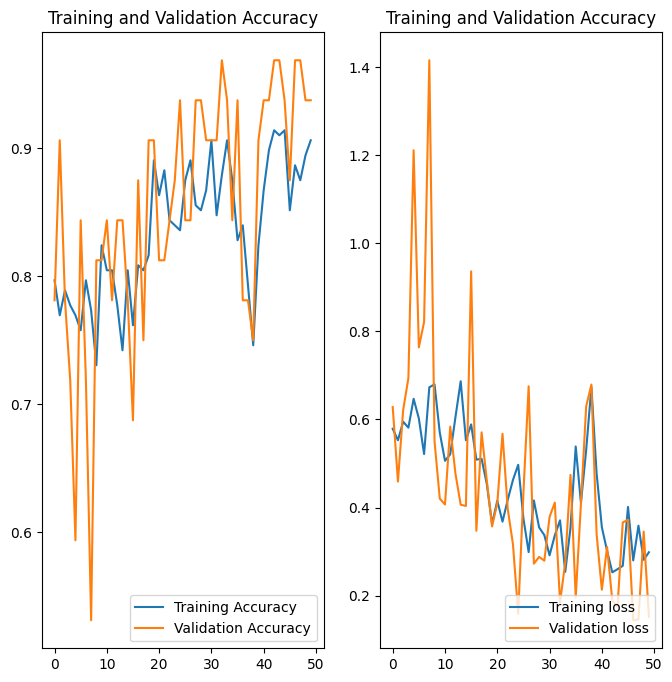

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")
plt.show()


### Testing

first image to predict
Actual label: elephant
1/1 [==============================] - 0s 40ms/step
Predicted Label:  elephant


(-0.5, 255.5, 255.5, -0.5)

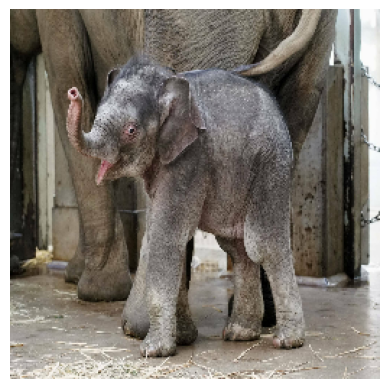

In [ ]:

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])
plt.axis('off')

In [ ]:
#Function to predict the animals class and generate confidence percentage
def predict(model ,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
# Plotting the actual and predicted label with the confidence score
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

### Visualising the convolution layers

1/1 [==============================] - 0s 170ms/step


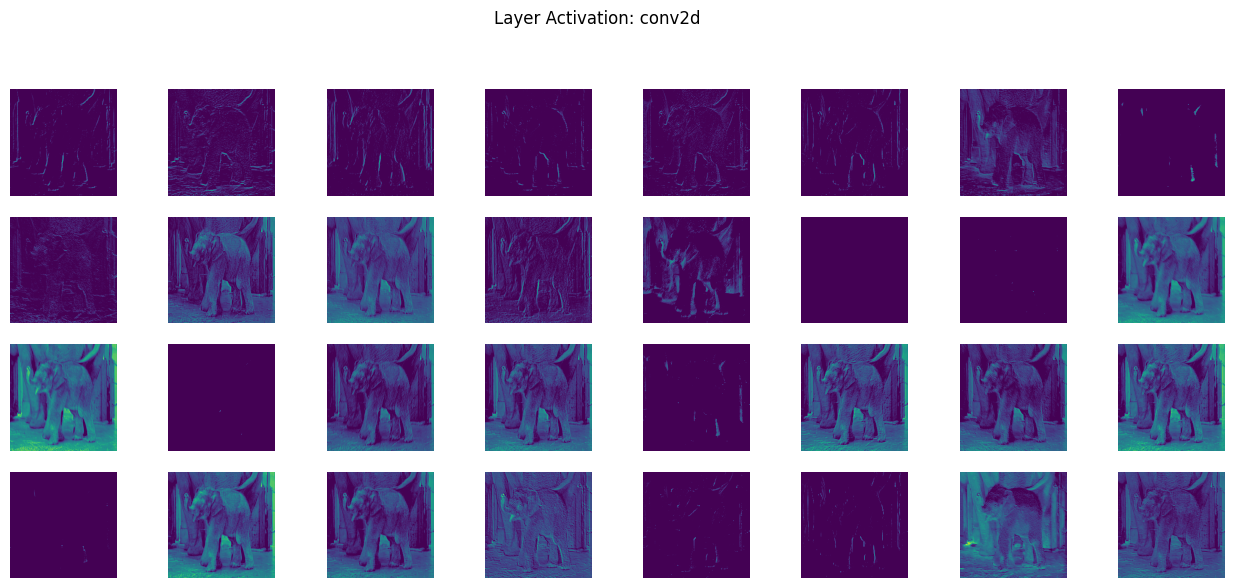

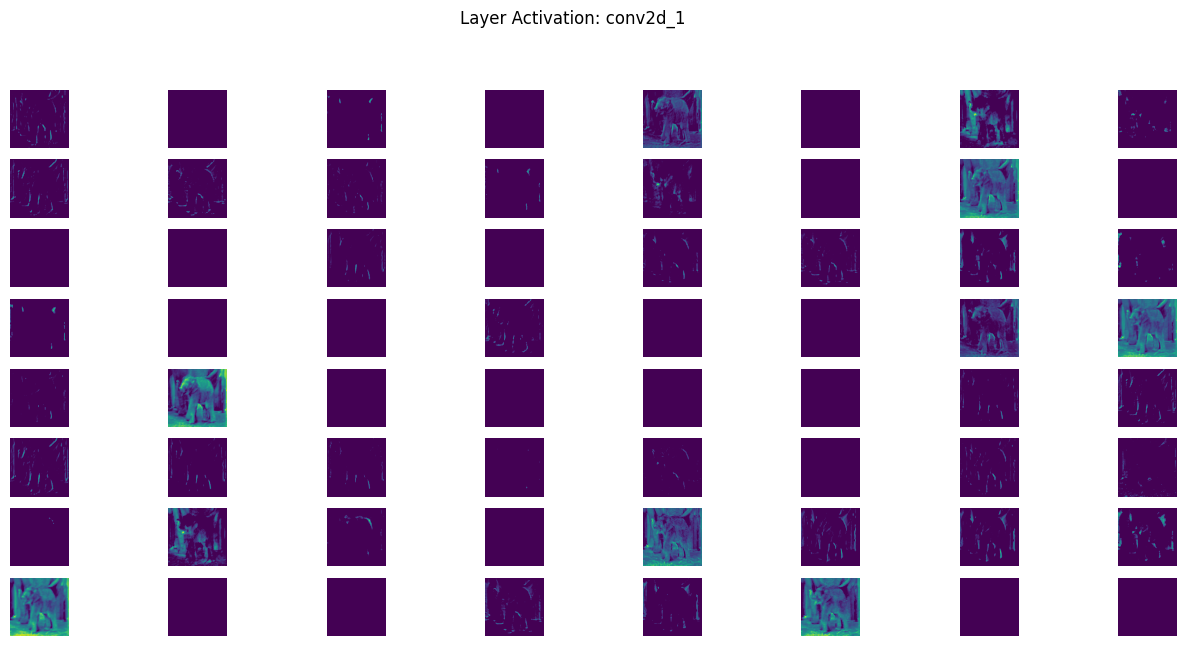

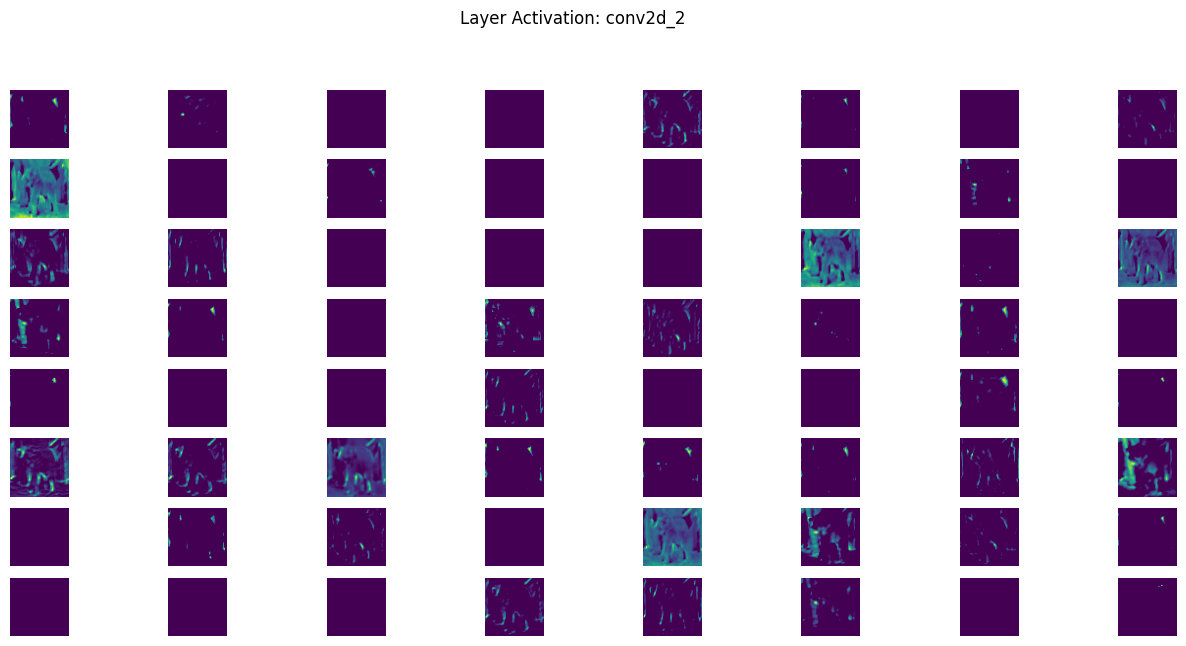

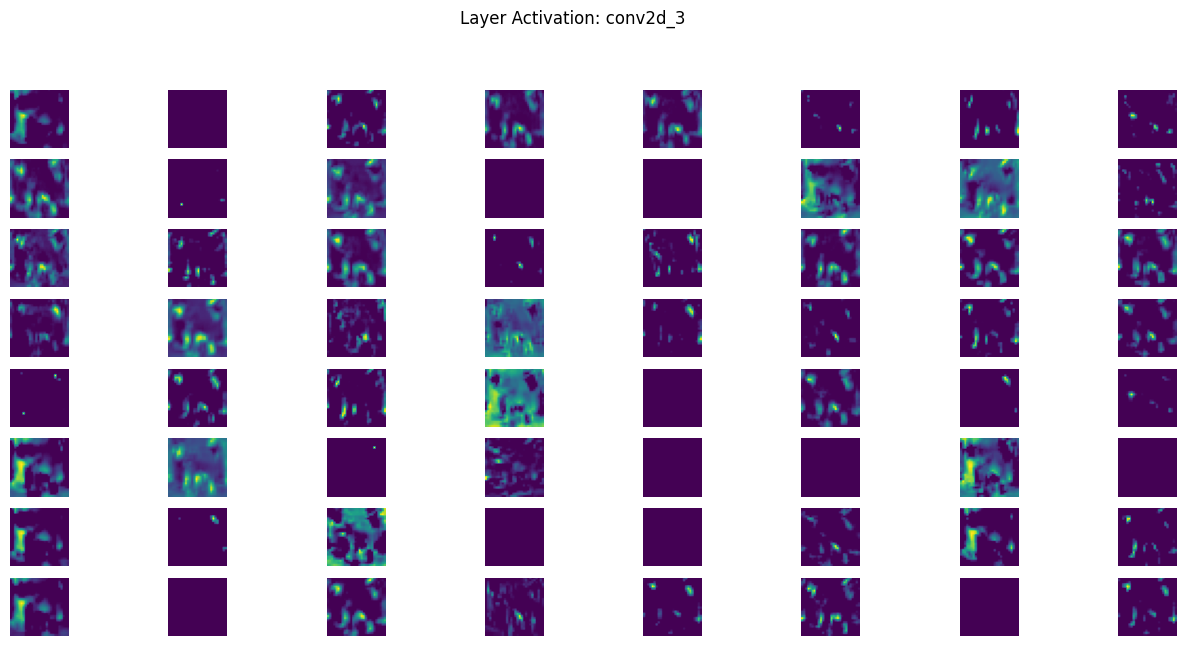

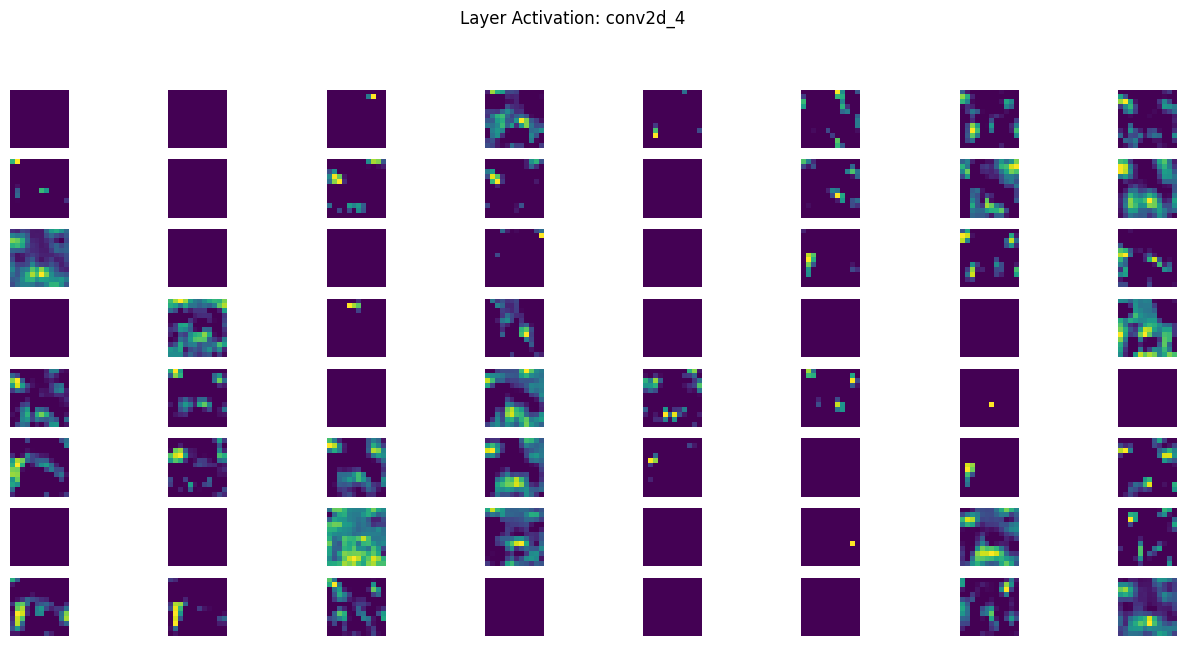

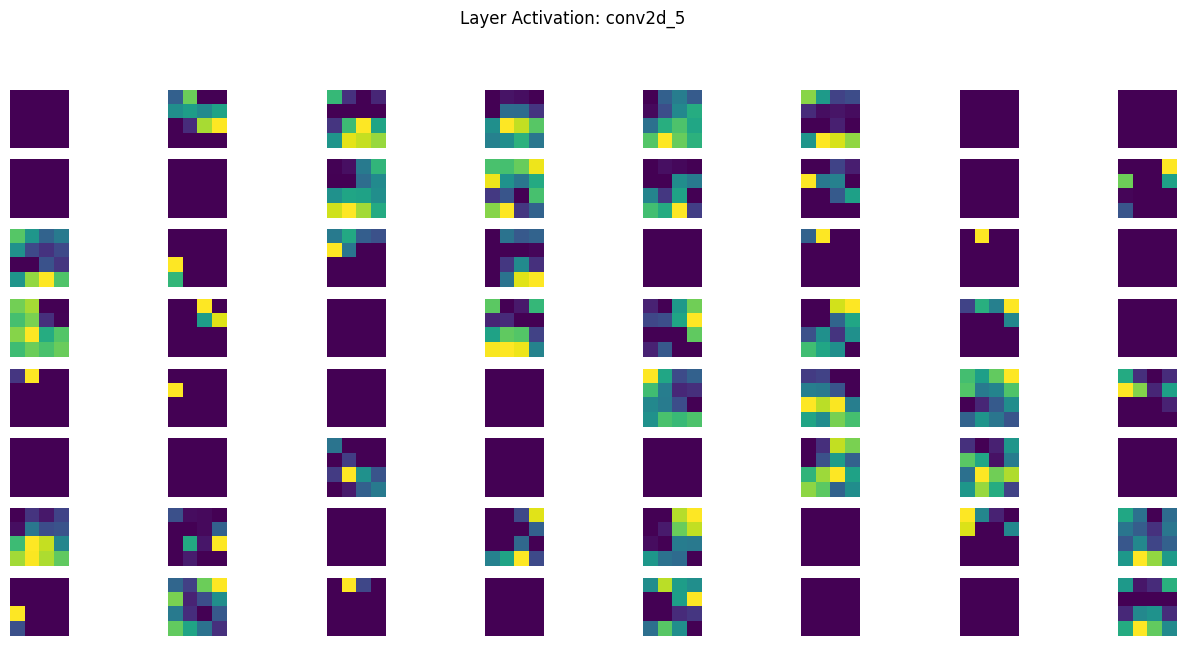

In [ ]:
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

layer_names = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

sample_image, _ = next(iter(test_ds))         # Select an image from your dataset

activations = activation_model.predict(sample_image)      # Get the activations for the sample image

for layer_activation, layer_name in zip(activations, layer_names):              # Plot the outputs of all convolutional layers
    n_filters = layer_activation.shape[-1]                                      # Number of filters in the layer
    n_cols = n_filters // 8 + 1                                                 # Number of columns for subplots
    plt.figure(figsize=(16, 8))
    for i in range(n_filters):
        plt.subplot(n_cols, 8, i+1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Layer Activation: {layer_name}')
    plt.show()

### K-fold cross validation (k=3)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from keras.layers import BatchNormalization, Dropout

true_labels = []
predicted_labels = []

train_images = np.concatenate(list(train_ds.map(lambda x, y: x)))     # Concatenate train and validation data
train_labels = np.concatenate(list(train_ds.map(lambda x, y: y)))
val_images = np.concatenate(list(val_ds.map(lambda x, y: x)))
val_labels = np.concatenate(list(val_ds.map(lambda x, y: y)))

inputs = np.concatenate((train_images, val_images), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Define model architecture
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

kfold = KFold(n_splits=3, shuffle=True)     # Define KFold cross-validation

# Initializing lists to store evaluation scores
all_losses = []
all_accuracies = []

# Iterating over each fold
for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(inputs, targets)):
    print(f"Fold {fold_idx + 1}")

    train_inputs, train_targets = inputs[train_idx], targets[train_idx]         # Split data into training and testing sets for this fold
    test_inputs, test_targets = inputs[test_idx], targets[test_idx]

    history = model.fit(train_inputs, train_targets,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(test_inputs, test_targets),
                        verbose=1)

    loss, accuracy = model.evaluate(test_inputs, test_targets, verbose=0)       # Evaluate the model on test data
    all_losses.append(loss)
    all_accuracies.append(accuracy)

    train_loss.append(history.history['loss'])                                   # Append training and validation accuracy and loss to lists
    train_accuracy.append(history.history['accuracy'])
    val_loss.append(history.history['val_loss'])
    val_accuracy.append(history.history['val_accuracy'])

    predictions = model.predict(test_inputs)
    # Convert predictions from probabilities to class labels
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(test_targets)

Fold 1
Epoch 1/50
6/6 [==============================] - 6s 186ms/step - loss: 2.3712 - accuracy: 0.2396 - val_loss: 1.6160 - val_accuracy: 0.1354
Epoch 2/50
6/6 [==============================] - 1s 113ms/step - loss: 1.7910 - accuracy: 0.3229 - val_loss: 1.6251 - val_accuracy: 0.1562
Epoch 3/50
6/6 [==============================] - 1s 100ms/step - loss: 1.6398 - accuracy: 0.3490 - val_loss: 1.6288 - val_accuracy: 0.1562
Epoch 4/50
6/6 [==============================] - 1s 113ms/step - loss: 1.4087 - accuracy: 0.4323 - val_loss: 1.6358 - val_accuracy: 0.1562
Epoch 5/50
6/6 [==============================] - 1s 100ms/step - loss: 1.4467 - accuracy: 0.3750 - val_loss: 1.6535 - val_accuracy: 0.1771
Epoch 6/50
6/6 [==============================] - 1s 100ms/step - loss: 1.3423 - accuracy: 0.4375 - val_loss: 1.6817 - val_accuracy: 0.2083
Epoch 7/50
6/6 [==============================] - 1s 113ms/step - loss: 1.2148 - accuracy: 0.5104 - val_loss: 1.7132 - val_accuracy: 0.1979
Epoch 8/50
6/

In [ ]:
# Calculating average evaluation scores across all folds
avg_loss = np.mean(all_losses)
avg_accuracy = np.mean(all_accuracies)

print("Average loss across all folds:", avg_loss)
print("Average accuracy across all folds:", avg_accuracy)

Average loss across all folds: 3.058295170466105
Average accuracy across all folds: 0.2986111094554265


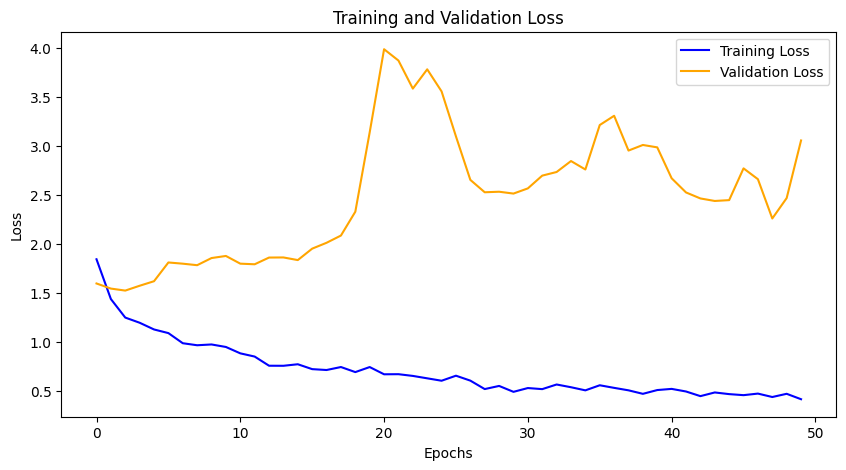

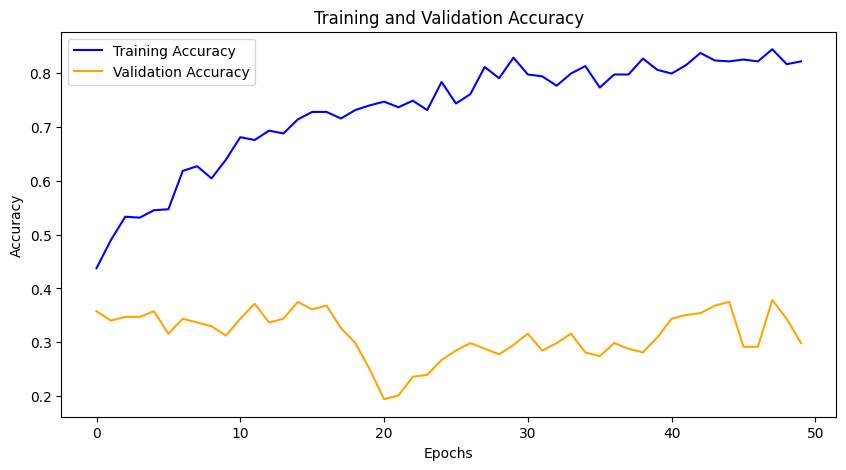

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(np.mean(train_loss, axis=0), label='Training Loss', color='blue')
plt.plot(np.mean(val_loss, axis=0), label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.mean(train_accuracy, axis=0), label='Training Accuracy', color='blue')
plt.plot(np.mean(val_accuracy, axis=0), label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

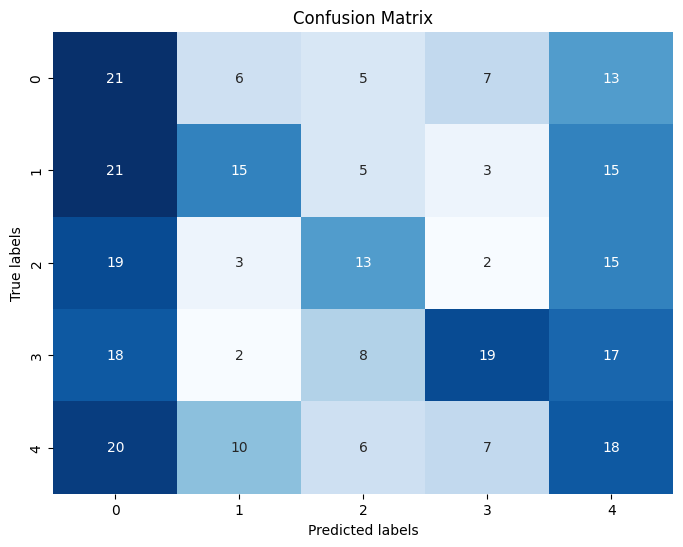

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

============================================**End of notebook**============================================